In [1]:
import numpy as np
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

# qiskit modules
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.providers.aer import noise

# tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
# importing IBMQ backends
from qiskit import IBMQ
ibmq_provider = IBMQ.load_account()  # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
simulator_noise = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmqx2')  #ibmq_burlington ibmq_16_melbourne ibmq_ourense

# needed for noisy simulator
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

/home/nico/Environments/dev_qiskit/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


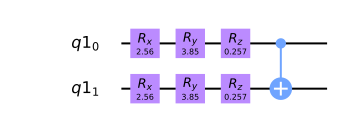

In [3]:
# creating a random initial state for 0th qbit
R = []
for i in range(3):
    R.append(10*random.random())

qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.rx(np.pi/5*R[0],0)
qc_expected.ry(np.pi/5*R[1],0)
qc_expected.rz(np.pi/5*R[2],0)
qc_expected.rx(np.pi/5*R[0],1)
qc_expected.ry(np.pi/5*R[1],1)
qc_expected.rz(np.pi/5*R[2],1)
# qc_expected.h(0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [0.81675228+0.j         0.08872804-0.16033422j 0.33326928-0.19646777j
 0.33326928-0.19646777j]


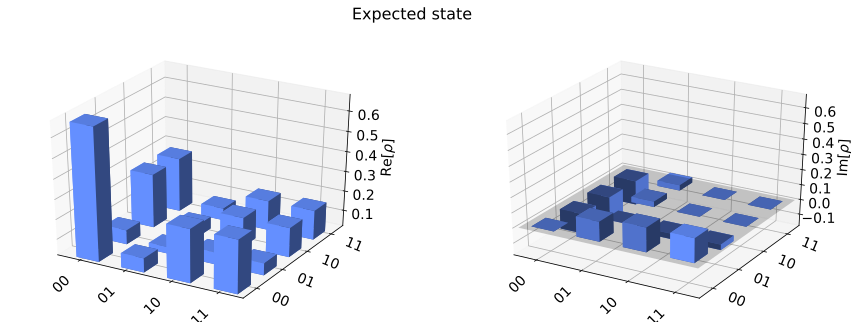

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

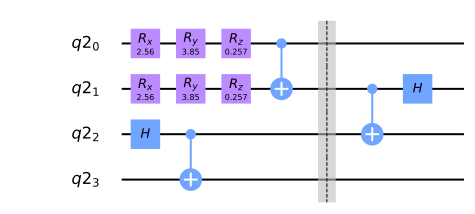

In [5]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)
qc = QuantumCircuit(qr)
qc.rx(np.pi/5*R[0],0)
qc.ry(np.pi/5*R[1],0)
qc.rz(np.pi/5*R[2],0)
qc.rx(np.pi/5*R[0],1)
qc.ry(np.pi/5*R[1],1)
qc.rz(np.pi/5*R[2],1)
# qc.h(0)
qc.h(2)
qc.cx(0,1)
qc.cx(2,3)
qc.barrier()
qc.cx(1,2)
qc.h(1)
qc.draw(output='mpl')

In [6]:
# #readout calibration measurements
# cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
# cal_job = qiskit.execute(cal_circuits, backend = device, shots = 1024, optimization_level = 0)
# job_monitor(cal_job)
# calres = cal_job.result()
# meas_fitter = CompleteMeasFitter(calres, state_labels)
# meas_fitter.plot_calibration()

In [7]:
# defining tomography circuits
qcz = state_tomography_circuits(qc,qr)
# the nine circuits are in the order [XZZX, XZZY, XZZZ, YZZX, YZZY, YZZZ, ZZZX, ZZZY, ZZZZ]
qst_circuit = [qcz[24],qcz[25],qcz[26],qcz[51],qcz[52],qcz[53],qcz[78],qcz[79],qcz[80]]

# drawing one of the tomography circuits to check
# qst_circuit[0].draw(output='mpl')

In [8]:
backends = [simulator, simulator_noise, device]
bits = [ '0000', '1000', '0001', '1001', '0010', '1010', '0011', '1011','0100', '1100', '0101', '1101', '0110', '1110', '0111', '1111']
paulis = [('X','Z','Z','X'),('Y','Z','Z','X'),('Z','Z','Z','X'),('X','Z','Z','Y'),('Y','Z','Z','Y'),('Z','Z','Z','Y'),('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']

for num, backend in enumerate(backends):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '01': 0, '10': 0, '11': 0}})
    state_df = pd.DataFrame(data=[state,state,state,state])
    
    if num == 0:
        job_sim = qiskit.execute(qst_circuit, backend, shots=8192) # for ideal simulator
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim = qiskit.execute(qst_circuit, backend, shots=8192,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 2:
        job_dev = qiskit.execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    
    # 4 possible outcomes of teleport protocol, where the final state is either
    # psi, IX @ psi, IZ @ psi, IZ @ IX @ psi. We store all 4 seperately, to then transform
    # the resulting density matrices appropriately before finding fidelity
    for i in range(4):
        for j in range(9):
            state_df.loc[i][basis[j]] = {'00': tom.data[(paulis[j])][bits[4*i]],
                                         '01': tom.data[(paulis[j])][bits[4*i+2]],
                                         '10': tom.data[(paulis[j])][bits[4*i+1]],
                                         '11': tom.data[(paulis[j])][bits[4*i+3]]}

    if num == 0:
        state_sim = state_df
        print('The full state for the simulator is', state_sim)
    if num == 1:
        state_sim_noise = state_df
        print('The full state for the noisy simulator is', state_sim_noise)
    if num == 2:
        state_dev = state_df
        print('The full state for the device is', state_dev)

The full state for the simulator is                                              XX  \
0  {'00': 1498, '01': 309, '10': 64, '11': 269}   
1  {'00': 57, '01': 285, '10': 1415, '11': 274}   
2  {'00': 1379, '01': 244, '10': 62, '11': 288}   
3  {'00': 54, '01': 279, '10': 1405, '11': 310}   

                                              YX  \
0  {'00': 516, '01': 1176, '10': 231, '11': 116}   
1  {'00': 231, '01': 121, '10': 524, '11': 1196}   
2  {'00': 516, '01': 1228, '10': 246, '11': 110}   
3   {'00': 236, '01': 91, '10': 484, '11': 1170}   

                                             ZX  \
0  {'00': 1421, '01': 309, '10': 273, '11': 61}   
1  {'00': 278, '01': 66, '10': 1413, '11': 316}   
2  {'00': 1410, '01': 299, '10': 282, '11': 48}   
3  {'00': 267, '01': 60, '10': 1381, '11': 308}   

                                              XY  \
0  {'00': 486, '01': 253, '10': 1014, '11': 290}   
1  {'00': 1026, '01': 294, '10': 454, '11': 281}   
2  {'00': 1049, '01': 271, '10': 46

In [9]:
# defining the matrices to form the basis for the 2 qbits
I_matrix = np.matrix('1, 0; 0, 1')
X_matrix = np.matrix('0, 1; 1, 0')
Y_matrix = np.matrix('0, 0-1j; 0+1j, 0')
Z_matrix = np.matrix('1, 0; 0, -1')
Iden = np.kron(I_matrix,I_matrix)

IXPaul = np.kron(I_matrix,X_matrix)
IYPaul = np.kron(I_matrix,Y_matrix)
IZPaul = np.kron(I_matrix,Z_matrix)

XIPaul = np.kron(X_matrix,I_matrix)
YIPaul = np.kron(Y_matrix,I_matrix)
ZIPaul = np.kron(Z_matrix,I_matrix)

XXPaul = np.kron(X_matrix,X_matrix)
XYPaul = np.kron(X_matrix,Y_matrix)
XZPaul = np.kron(X_matrix,Z_matrix)

YXPaul = np.kron(Y_matrix,X_matrix)
YYPaul = np.kron(Y_matrix,Y_matrix)
YZPaul = np.kron(Y_matrix,Z_matrix)

ZXPaul = np.kron(Z_matrix,X_matrix)
ZYPaul = np.kron(Z_matrix,Y_matrix)
ZZPaul = np.kron(Z_matrix,Z_matrix)

In [10]:
# there are 4 density matrices to calculate for each of sim, sim_noise and dev

# XX, XY, XZ etc are 9 total r_xx etc terms to calculate
r_exp = np.zeros((4, 9))
# there are three 
r_IP = np.zeros((4, 9))
r_PI = np.zeros((4, 9))
r_IPavg = np.zeros((4, 3))
r_PIavg = np.zeros((4, 3))

state_tot=[state_sim,state_sim_noise,state_dev]
rho=[0,0,0]
basis2 = ['XX','XY','XZ','YX','YY','YZ','ZX','ZY','ZZ']

for stat, states in enumerate(state_tot):
    rhof=[0,0,0,0]
    for i in range(4):
        for j in range(9):
            r_exp[i,j] = (state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(-1) + state_tot[stat][basis[j]][i]['01']*(-1) + state_tot[stat][basis[j]][i]['11']*1)/(state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1) + state_tot[stat][basis[j]][i]['01']*(1) + state_tot[stat][basis[j]][i]['11']*1)
            r_IP[i,j] = (state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1) + state_tot[stat][basis[j]][i]['01']*(-1) + state_tot[stat][basis[j]][i]['11']*(-1))/(state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1) + state_tot[stat][basis[j]][i]['01']*(1) + state_tot[stat][basis[j]][i]['11']*1)
            r_PI[i,j] = (state_tot[stat][basis2[j]][i]['00']*1 + state_tot[stat][basis2[j]][i]['10']*(-1) + state_tot[stat][basis2[j]][i]['01']*(1) + state_tot[stat][basis2[j]][i]['11']*(-1))/(state_tot[stat][basis2[j]][i]['00']*1 + state_tot[stat][basis2[j]][i]['10']*(1) + state_tot[stat][basis2[j]][i]['01']*(1) + state_tot[stat][basis2[j]][i]['11']*1)
    for i in range(4):
        for j in range(3):
                r_IPavg[i,j]  = (r_IP[i,3*j] + r_IP[i,3*j+1] + r_IP[i,3*j+2])/3
                r_PIavg[i,j] = (r_PI[i,3*j] + r_PI[i,3*j+1] + r_PI[i,3*j+2])/3
    for i in range(4):
        rhof[i] = (1/4)*(Iden + r_exp[i,0]*XXPaul + r_exp[i,1]*XYPaul + r_exp[i,2]*XZPaul
                              + r_exp[i,3]*YXPaul + r_exp[i,4]*YYPaul + r_exp[i,5]*YZPaul
                              + r_exp[i,6]*ZXPaul + r_exp[i,7]*ZYPaul + r_exp[i,8]*ZZPaul
                              + r_IPavg[i,0]*IXPaul + r_PIavg[i,0]*XIPaul
                              + r_IPavg[i,1]*IYPaul + r_PIavg[i,1]*YIPaul
                              + r_IPavg[i,2]*IZPaul + r_PIavg[i,2]*ZIPaul)
    rho[stat] = rhof

for ind in range(3):
    rho[ind][1] = ZIPaul @ rho[ind][1] @ ZIPaul
    rho[ind][2] = XIPaul @ rho[ind][2] @ XIPaul
    rho[ind][3] = XIPaul @ ZIPaul @ rho[ind][3] @ ZIPaul @ XIPaul

In [11]:
# r_cor = np.zeros((4,9))
# # haven't implemented readout calibration for 2 qbits yet, so r_cor = r_dev
# r_cor = r_dev
# # r_cor[:,:] = (r_dev[:,:] - beta0) / beta1

In [12]:
np.outer(psi_expected,psi_expected)

array([[ 0.66708429+0.j        ,  0.07246883-0.13095334j,
         0.27219844-0.1604655j ,  0.27219844-0.1604655j ],
       [ 0.07246883-0.13095334j, -0.0178344 -0.02845228j,
        -0.00193018-0.07086667j, -0.00193018-0.07086667j],
       [ 0.27219844-0.1604655j , -0.00193018-0.07086667j,
         0.07246883-0.13095334j,  0.07246883-0.13095334j],
       [ 0.27219844-0.1604655j , -0.00193018-0.07086667j,
         0.07246883-0.13095334j,  0.07246883-0.13095334j]])

In [13]:
Fidelity = np.zeros((3,4))
for i in range(3):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[i][j], validate=False)
print(Fidelity)

F = np.mean(Fidelity,axis=1)
print('Simulator Fidelity:', F[0])
print('Noisy Simulator Fidelity:', F[1])
print('Device Fidelity:', F[2])
# print('Corrected Device Fidelity:', F[3])

[[0.77140467 0.71971225 0.75365778 0.86829935]
 [0.71523767 0.66169811 0.70111574 0.82698292]
 [0.65595998 0.45303642 0.64366912 0.63441271]]
Simulator Fidelity: 0.778268512330012
Noisy Simulator Fidelity: 0.7262586115791796
Device Fidelity: 0.5967695584531365


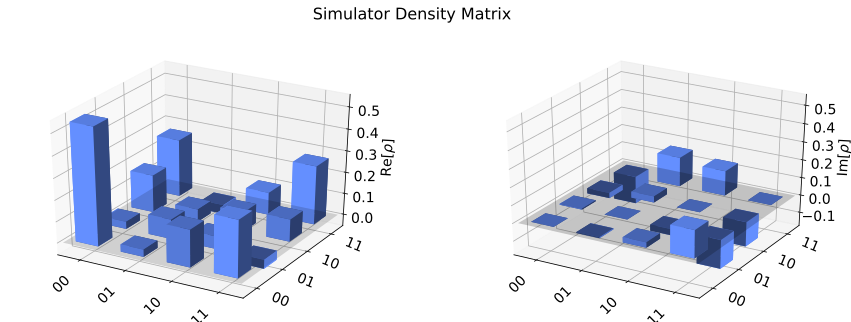

In [14]:
plot_state_city(rho[0][0], title='Simulator Density Matrix')

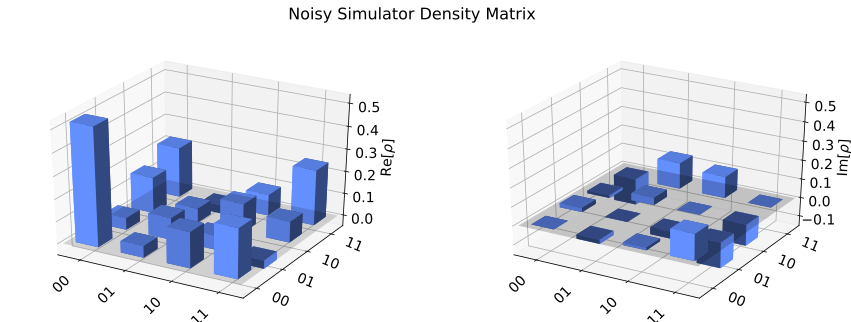

In [15]:
plot_state_city(rho[1][0], title='Noisy Simulator Density Matrix')

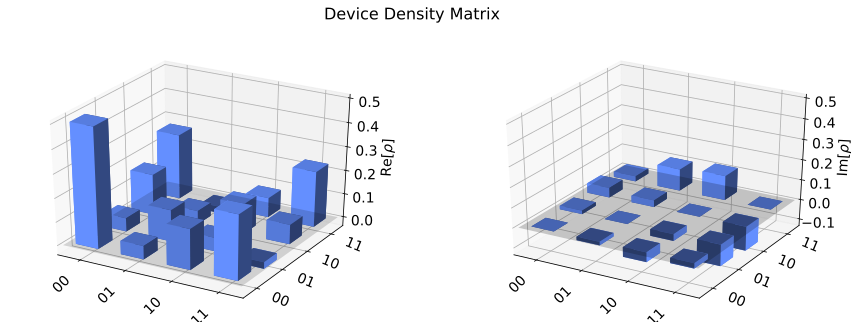

In [16]:
plot_state_city(rho[2][0], title='Device Density Matrix')

In [17]:
# checking validity of the density matrices
rho_sim = DensityMatrix(rho[0][1])
rho_dev = DensityMatrix(rho[0][2])
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

Is the simulator density matrix valid? False
Is the device density matrix valid? False


In [18]:
import qiskit.tools.jupyter
%qiskit_version_table